In [1]:
import pathlib, sys, os, random, time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

/home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/mdi220/anaconda3/envs/torch/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# mounting google drive
collaboratory = False

if collaboratory:
    from google.colab import drive
    drive.mount('/gdrive')
    # !ln -s "/gdrive/Shareddrives/HSC_project/HSC_ML" "/content/HSC_ML"
    os.chdir("/gdrive/Shareddrives/HSC_project/HSC_ML")
else: 
    print('Running on local systems, if running on collaboratory please change above')

print(os.listdir())
# print(os.getcwd())
#!unzip ./HSC_ML/Output/TBCells_crops.zip -d ./HSC_ML/Output/

Running on local systems, if running on collaboratory please change above
['Note.txt', 'test.ipynb', 'test copy.ipynb', 'Training_khayrul.ipynb', 'Training.ipynb']


# spliting dataset into train and test

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    #transforms.RandomRotation(90),
    transforms.RandomRotation(degrees=(90, 90)),
    transforms.RandomRotation(degrees=(270, 270)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor()])

In [7]:
import torch
from torchvision import datasets

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

# # EXAMPLE USAGE:
# # instantiate the dataset and dataloader
# data_dir = "your/data_dir/here"
# dataset = ImageFolderWithPaths(data_dir) # our custom dataset
# dataloader = torch.utils.DataLoader(dataset)

# # iterate over data
# for inputs, labels, paths in dataloader:
#     # use the above variables freely
#     print(inputs, labels, paths)

In [9]:
import sklearn.model_selection

if collaboratory:
  image_folder = "./Output/"
else:
  image_folder = "../../Output/TBCells_crops/Train_data/"
trained_weights = image_folder[:-11]+"Results/Latest_Weight/"

if not os.path.exists(trained_weights):
        os.makedirs(trained_weights)


dataset = ImageFolderWithPaths(image_folder, transform=train_transform)
print(dataset.class_to_idx)
train_indices, val_indices = sklearn.model_selection.train_test_split(
                    list(range(dataset.__len__())),          # list of indices of dataset
                    stratify = dataset.targets,                 # for stratify sampling the data due to the unblanced dataset
                    random_state = 42,
                    test_size=.25                               #represent the proportion of the dataset to include in the train split.
                    )



# subsetting the dataset into train and test
training_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, val_indices) 

print(f"Length of dataset:" )
print(f" {'Train dataset':<12}   \u2502   {'Test data':>12} ")
print(f" {len(training_data):<12}    \u2502   {len(test_data) :>12}")



{'BCells_Old_crops': 0, 'TCells_Old_crops': 1}
Length of dataset:
 Train dataset   │      Test data 
 24558           │           8186


# Iterating and Visualizing the Dataset

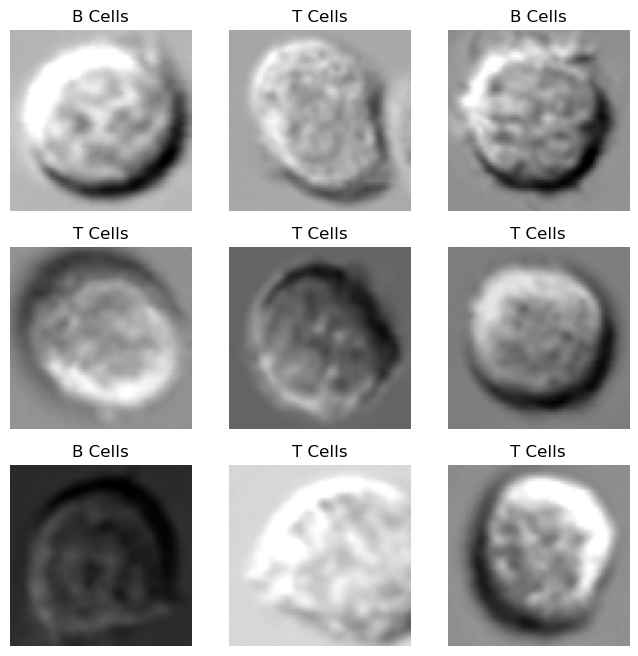

In [11]:
labels_map = {
    0: "B Cells",
    1: "T Cells",
    #2: "T8 Cells",

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label, _ = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") 
plt.show()

In [13]:

batch_size = 64

# setting sampler weight
y_train_indices = training_data.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size= batch_size,sampler = sampler, pin_memory=True, )
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=True)

for X, y, _ in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 64, 64])
Shape of y:  torch.Size([64]) torch.int64


# Training the model

In [14]:
# defining the model

import torchvision.models as models

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print("Cuda acceleration enabled!" if torch.cuda.is_available() else 'Running on CPU')


def get_model():
    # initializing with resnet weight
    model = models.resnet50(weights="IMAGENET1K_V2")

    # get the input feature in fully connected layer
    num_in_features = model.fc.in_features

    # Replace the final fully connected layer to suite the problem
    model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 128),
                                    nn.Linear(128, 32),
                                    nn.Linear(32, 3))
    
    # using gpu
    model = model.cuda() if torch.cuda.is_available() else model
    # print(model)
    return model


@torch.no_grad()
def validation(model, train_dataloader, loss_fn):
    losses = []
    model.eval()
    for image, target in train_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce_fn = nn.CrossEntropyLoss()
    loss = bce_fn(y_pred, y_true)
    return loss


### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}' + '\t' + '\u2502 {}'


Cuda acceleration enabled!


In [15]:
# loading the model

model = get_model()

model.to(DEVICE)

# not optimizing the whole network for now
# optimizer = torch.optim.AdamW(model.parameters(),
#                   lr=1e-4, weight_decay=1e-3)

ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())
#??? why we have 2 learning rate
learning_rate = 4e-3
optimizer = torch.optim.Adam([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': learning_rate}
        ], lr = learning_rate * 0.01)

In [ ]:
EPOCHES = 35
vloss_min = np.Inf
print(header)

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target, _ in train_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    vloss = validation(model, test_dataloader, loss_fn)
    batch_loss = np.array(losses).mean()
    
    if vloss_min > vloss:
        vloss_min = vloss
        torch.save(model.state_dict(), trained_weights +'TBCells.pt')
        save_status = 'Yes'
    else:
        save_status = 'No'
        
    print(raw_line.format(epoch, batch_loss, vloss,
                              (time.time()-start_time)/60**1, save_status))

# Reconstruct model from saved weights

In [ ]:
restart = False
if restart:
    model1 = torchvision.models.resnet50()
    model1.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=2048,
            out_features=1
        ),
        torch.nn.Sigmoid()
    )
    model1.load_state_dict(torch.load(trained_weights +'TBCells.pt'))

# Evaluating results

In [22]:
# validating dataset

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import shutil

# defining hook to access output from intermidiate layer
def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

# registerning the hook. different layer can be accessed by changing
# fc[3] parameter. for details 
# https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/05/27/extracting-features.html
model.fc[3].register_forward_hook(get_features('feats'))


trained_model_PATH = trained_weights +'TBCells.pt'
model.load_state_dict(torch.load(trained_model_PATH))
model.eval()

y_pred = []
y_true = []
FEATS = [] # extracted feats will be saved here
# placeholder for batch features
features = {}


with torch.no_grad():
    for image, target, path in test_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        outputs = model(image)
        output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        target = target.data.cpu().numpy()
        
        # not_matched = [target.index(y) for x, y in zip(y_pred, target) if y != x]
        not_matched = np.where(y_pred != target)[0]
        for element in not_matched:
            shutil.copy(path[element], trained_weights + "wrong_pred/" + path[element].split("/")[-1]) 
        y_true.extend(target) # Save Truth
        FEATS.extend((features['feats'].cpu().numpy())) # Save feature
       
print(f' Feature extracted with shape: {np.array(FEATS).shape}')

/tmp/ipykernel_1911771/3900963466.py:40: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  not_matched = np.where(y_pred != target)[0]


 Feature extracted with shape: (8186, 128)


In [ ]:
classes = labels_map.values()   
 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

class_accuracy=np.mean(100*cf_matrix.diagonal()/cf_matrix.sum(1))
print(f'average acuraccy of all classes: {class_accuracy}')

# ploting 
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)
fig, ax = plt.subplots( dpi = 150)
sn.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title(f'Confusion Matrix, average acuracy: {class_accuracy :.2f}', fontsize = 15)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.xlabel('Predicted'); plt.ylabel('True');

plt.savefig(trained_weights + 'cf_matrix.png', bbox_inches='tight')

In [ ]:
# classification report

from sklearn.metrics import classification_report
import seaborn as sns

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(cls_report)
# df.drop(columns=['accuracy'])

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig(trained_weights + "classification_report.png", bbox_inches='tight', dpi=150)

In [ ]:
# T-SNE plot

from sklearn.manifold import TSNE
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2, verbose=0)
tsne_proj = tsne.fit_transform(FEATS)
# Plot those points as a scatter plot and label them based on the pred labels

cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))

for lab in range(len(labels_map)):
    indices = np.array(y_pred)==lab
    #ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.savefig(trained_weights + "T-SNE.png", bbox_inches='tight', dpi=150)

In [ ]:
#pip install keyboard
#import keyboard
#keyboard.press_and_release('command+s')

nb_name = "test.ipynb"
nb_full_path = os.path.join(os.getcwd(), nb_name)

import shutil
shutil.copyfile(nb_full_path, trained_weights  + nb_name)
